# DATASCI W261: Machine Learning at Scale
## Assignment Week 2
Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 

### HW2.0:

#### What is a race condition in the context of parallel computation? Give an example.
A race condition is when a section of code is executed by multiple processes, and the order in which the processes execute will impact the final result.

![Race condition example](race_conditions.png)
Source: https://en.wikipedia.org/wiki/Race_condition#Example

#### What is MapReduce?
MapReduce can refer to multiple concepts:
- **Programming model:** Processes are split into a "mapping" phase, and a "reducing" phase. In the map phase, a certain function is mapped on to each value in a data set, and then in the reduce phase, the result of the map phase is aggregated. 
- **Execution framework:** This framework coordinates running processes written with the above model in mind.
- **Software implementation:** MapReduce is the name of Google's proprietary implementation of this programming model, while Apache Hadoop is the open-source implementation.

#### How does it differ from Hadoop?
Hadoop is the open-source implementation of Google's MapReduce. Hadoop consists of two parts: distributed storage of data, and distributed processing of data. HDFS is the storage part, and MapReduce is the processing part.

#### Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.
Hadoop is based on the MapReduce paradigm. The classic example of the MapReduce programming paradigm is word count. In the map phase of word count, each word in a document is assigned a count of 1. In the reduce phase, the counts for each unique word are summed to yield the final count of each word.

In [20]:
def hw2_0():
    doc = "Hello this is a test to test word count test should have a count of three".lower()
    key_vals = []
    
    print "MAP PHASE"
    for word in doc.split():
        print [word, 1]
        key_vals.append([word, 1])
    
    print "\nREDUCE PHASE"
    key_vals = sorted(key_vals)
    
    current_word = None
    current_count = 0
    
    for pair in key_vals:
        if current_word == pair[0]:
            print [current_word, current_count], "(intermediate step)"
            current_count += pair[1]
        else:
            if current_word:
                print [current_word, current_count], "FINAL SUM"
            current_word = pair[0]
            current_count = pair[1]

    print [current_word, current_count], "FINAL SUM"
    
hw2_0()

MAP PHASE
['hello', 1]
['this', 1]
['is', 1]
['a', 1]
['test', 1]
['to', 1]
['test', 1]
['word', 1]
['count', 1]
['test', 1]
['should', 1]
['have', 1]
['a', 1]
['count', 1]
['of', 1]
['three', 1]

REDUCE PHASE
['a', 1] (intermediate step)
['a', 2] FINAL SUM
['count', 1] (intermediate step)
['count', 2] FINAL SUM
['have', 1] FINAL SUM
['hello', 1] FINAL SUM
['is', 1] FINAL SUM
['of', 1] FINAL SUM
['should', 1] FINAL SUM
['test', 1] (intermediate step)
['test', 2] (intermediate step)
['test', 3] FINAL SUM
['this', 1] FINAL SUM
['three', 1] FINAL SUM
['to', 1] FINAL SUM
['word', 1] FINAL SUM


### HW2.1: Sort in Hadoop MapReduce
**Given as input: Records of the form `<integer, “NA”>`, where integer is any integer, and “NA” is just the empty string.**<br>
**Output: Sorted key value pairs of the form `<integer, “NA”>`; what happens if you have multiple reducers? Do you need additional steps? Explain.**

If there are multiple reducers, then a straightforward MapReduce process will yield outputs that are sorted within each reducer, but not sorted across all reducers. In order to output a sort across all reducers, an extra step needs to be implemented that will intelligently send keys to reducers so that the result from all reducers will yield a complete sort. For example, let's say our keys ranged from 0-300. If we had 3 reducers, we could send all keys in the range [0,100) to reducer 1, [100, 200) to reducer 2, and [200, 300] to reducer 3. Thus, the output of each reducer will yield documents that are completely sorted. We would need to balance the keys sent to each reducer to ensure that the load is still balanced between all reducers, which will require some calculations.

#### Write code to generate N  random records of the form `<integer, “NA”>`. Let N = 10,000.

We are going to need the Hadoop Streaming jar file, so let's download it here so that we know which one to use

In [22]:
!wget http://central.maven.org/maven2/org/apache/hadoop/hadoop-streaming/2.7.1/hadoop-streaming-2.7.1.jar

--2016-01-21 18:37:45--  http://central.maven.org/maven2/org/apache/hadoop/hadoop-streaming/2.7.1/hadoop-streaming-2.7.1.jar
Resolving central.maven.org... 23.235.47.209
Connecting to central.maven.org|23.235.47.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105736 (103K) [application/java-archive]
Saving to: “hadoop-streaming-2.7.1.jar”

100%[======================================>] 105,736     --.-K/s   in 0.1s    

2016-01-21 18:38:00 (1.06 MB/s) - “hadoop-streaming-2.7.1.jar” saved [105736/105736]



In [1]:
import random

with open("random.txt", "w") as myfile:
    for i in range(10000):
        myfile.write("{:d},{:s}\n".format(random.randint(0, 100000), "NA"))

#### Write the Python Hadoop streaming map-reduce job to perform this sort.

In [44]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.1

import sys

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    # In this case, we do not need to map the input to anything
    key, value = line.strip().split(',')
    print "%010d\t%s" % (int(key), value)

Overwriting mapper.py


In [45]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.1

from operator import itemgetter
import sys

for line in sys.stdin:
    # In this case, we do not need to reduce anything
    key, value = line.strip().split('\t')
    print "%d\t%s" % (int(key), value)

Overwriting reducer.py


In [1]:
# Make HDFS directory and put random.txt there
!hdfs dfs -mkdir /user/miki/week02
!hdfs dfs -put random.txt /user/miki/week02

In [49]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# If output folder already exists, delete it
!hdfs dfs -rm -r /user/miki/week02/hw2_1_output

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapred.reduce.tasks=4 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py \
-input /user/miki/week02/random.txt \
-output /user/miki/week02/hw2_1_output

16/01/22 12:59:13 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/miki/week02/hw2_1_output
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob4129142604574616452.jar tmpDir=null
16/01/22 12:59:16 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/22 12:59:17 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/22 12:59:17 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/22 12:59:17 INFO mapreduce.JobSubmitter: number of splits:2
16/01/22 12:59:17 INFO Configuration.deprecation: mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
16/01/22 12:59:17 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453405632837_0022
16/01/22 12:59:18 INFO impl.YarnClientImpl: Submitted application application_1453405632837_0022
16/01/22 12:59:18 INFO mapreduce.Job: The url to track the job: http://quick

In [52]:
!hdfs dfs -cat /user/miki/week02/hw2_1_output/part-00000

### HW2.2: Using the Enron data from HW1 and Hadoop MapReduce streaming, write mapper/reducer pair that  will determine the number of occurrences of a single, user-specified word. 

Examine the word “assistance” and report your results. To do so, make sure that mapper.py counts all occurrences of a single word, and reducer.py collates the counts of the single word.

#### Load enronemail_1h.txt into HDFS

In [47]:
!hdfs dfs -put enronemail_1h.txt /user/miki/week02

In [93]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.2

import sys
import string
import re

# Keyword from user input
keyword = sys.argv[1]

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields
    # Replace commas with spaces (we are using commas as a delimiter as well)
    # Remove remaining punctuation from subject and body
    # Concatenate, then split subject and body by spaces
    # Some records are malformed -- if there is a 4th field, use it
    fields = line.strip().split('\t')
    subj = fields[2].replace(',', ' ')
    subj = subj.translate(string.maketrans("",""), string.punctuation)
    if len(fields) == 4:
        body = fields[3].replace(',', ' ')
        body = body.translate(string.maketrans("",""), string.punctuation)
    else:
        body = ""
    words = subj + " " + body
    words = words.split()
    
    # Loop through words
    # If word is keyword, write to file
    # key = word
    # value = 1
    for word in words:
        if keyword == word:
            print "%s\t%s" % (word, 1)

Overwriting mapper.py


In [94]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.2

from operator import itemgetter
import sys

# Initialize some variables
# We know that the words will be sorted
# We need to keep track of state
prev_word = None
prev_count = 0
word = None

for line in sys.stdin:
    # Strip and split line from mapper
    word, count = line.strip().split('\t', 1)
    
    # If possible, turn count into an int (it's read as a string)
    try:
        count = int(count)
    except ValueError:
        # We couldn't make count into an int, so move on
        continue
        
    # Since the words will be sorted, all counts for a word will be grouped
    if prev_word == word:
        # If prev_word is word, then we haven't changed words
        # Just update prev_count
        prev_count += count
    else:
        # We've encountered a new word!
        # This might be the first word, though
        if prev_word:
            # We need to print the last word we were on
            print "%s\t%s" % (prev_word, prev_count)
        
        # Now we need to initialize our variables for the new word and count
        prev_word = word
        prev_count = count

# We have reached the end of the file, so print the last word and count
if prev_word == word:
    print "%s\t%s" % (prev_word, prev_count)

Overwriting reducer.py


#### Run Hadoop streaming command

In [95]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_2_output

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-mapper '/home/cloudera/Documents/W261-Fall2016/Week02/mapper.py assistance' \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py \
-input /user/miki/week02/enronemail_1h.txt \
-output /user/miki/week02/hw2_2_output

16/01/22 13:59:07 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/miki/week02/hw2_2_output
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob2515332195244567054.jar tmpDir=null
16/01/22 13:59:10 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/22 13:59:10 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/22 13:59:10 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/22 13:59:10 INFO mapreduce.JobSubmitter: number of splits:2
16/01/22 13:59:11 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453405632837_0027
16/01/22 13:59:11 INFO impl.YarnClientImpl: Submitted application application_1453405632837_0027
16/01/22 13:59:11 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1453405632837_0027/
16/01/22 13:59:11 INFO mapreduce.Job: Running job: job_1453405

#### Look at output of job

In [96]:
!hdfs dfs -cat /user/miki/week02/hw2_2_output/part-00000

assistance	10


### HW2.2.1: Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

In [ ]:
##############################
#
#    DO THIS!!!!!!!
#
##############################

### HW2.3: Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimited tokens as independent input variables (assume spaces, fullstops, commas as delimiters). 

Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

$$
\frac{\text{number of times "assistance" occurs in SPAM labeled documents}}{\text{the number of words in documents labeled SPAM}}
$$

#### Mapper/Reducer for fitting NB

Mapper:
- Input: training documents
- Output: (word, 1, 0) if word was in spam, otherwise (word, 0, 1)
  - Special words: \*alldocs, \*docs and \*words
  
Reducer:
- Input: (word, 1, 0) or (word, 0, 1)
- Output: (word, spam count, ham count)

In [39]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.3

import sys
import string
import re

counts = {
    '*words':{
        '1':0,
        '0':0
    },
    '*docs':{
        '1':0,
        '0':0
    }
}
total_docs = 0

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields
    # Replace commas with spaces (we are using commas as a delimiter as well)
    # Remove remaining punctuation from subject and body
    # Concatenate, then split subject and body by spaces
    # Some records are malformed -- if there is a 4th field, use it
    fields = line.strip().split('\t')
    
    # Keep track of document counts
    spam = fields[1]
    counts['*docs'][spam] += 1
    total_docs += 1
    
    subj = fields[2].replace(',', ' ')
    subj = subj.translate(string.maketrans("",""), string.punctuation)
    if len(fields) == 4:
        body = fields[3].replace(',', ' ')
        body = body.translate(string.maketrans("",""), string.punctuation)
    else:
        body = ""
    words = subj + " " + body
    words = words.split()
    
    # Loop through words
    # If word is not trivial, write to file
    # key = word
    # value = 1
    for word in words:
        if len(word) > 0 and repr(word)[1] != '\\':
            if spam == '1':
                print "%s\t%s\t%s" % (word, 1, 0)
            elif spam == '0':
                print "%s\t%s\t%s" % (word, 0, 1)
            counts['*words'][spam] += 1

# At the end, output document and word counts
for item in counts:
    print "%s\t%s\t%s" % (item, counts[item]['1'], counts[item]['0'])
print "%s\t%s\t%s" % ('*alldocs', total_docs, total_docs)


Overwriting mapper.py


In [40]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.3

from operator import itemgetter
import sys
import math

# Initialize some variables
# We know that the words will be sorted
# We need to keep track of state
prev_word = None
prev_spam_count = 0
prev_ham_count = 0
word = None

for line in sys.stdin:
    # Split line into fields
    fields = line.strip().split('\t')
    word = fields[0]
    spam_count = fields[1]
    ham_count = fields[2]
    
    # If possible, turn count into an int (it's read as a string)
    try:
        spam_count = int(spam_count)
        ham_count = int(ham_count)
    except ValueError:
        # We couldn't make count into an int, so move on
        continue
        
    if prev_word == word:
        # We have not moved to a new word
        # Just update the count of this word
        prev_spam_count += spam_count
        prev_ham_count += ham_count
        
    else:
        # We have encountered a new word!
        # If this is the first word, we don't need to print anything
        if prev_word: 
            # Write the previous word to file
            print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)
            
        # Now we need to initialize our variables
        prev_word = word
        prev_spam_count = spam_count
        prev_ham_count = ham_count

# We've reached the end of the file
# Print the last word and counts
print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)

Overwriting reducer.py


In [41]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_3_output_fit

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-input /user/miki/week02/enronemail_1h.txt \
-output /user/miki/week02/hw2_3_output_fit \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 


16/01/23 02:24:29 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/miki/week02/hw2_3_output_fit
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob1294460146102016869.jar tmpDir=null
16/01/23 02:24:33 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/23 02:24:33 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/23 02:24:33 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/23 02:24:33 INFO mapreduce.JobSubmitter: number of splits:2
16/01/23 02:24:34 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453405632837_0143
16/01/23 02:24:34 INFO impl.YarnClientImpl: Submitted application application_1453405632837_0143
16/01/23 02:24:34 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1453405632837_0143/
16/01/23 02:24:34 INFO mapreduce.Job: Running job: job_145

In [43]:
#!hdfs dfs -cat /user/miki/week02/hw2_3_output_fit/part-00000

#### Mapper/Reducer #1 for predicting NB

Mapper:
- Input from fit: (word, spam count, ham count)
- Output: (word, spam count, ham count)
- Input testing document: (document ID, cat, subj, body)
- Output: (word, cat, document ID)

Reducer:
- Input: (word, spam count, ham count)
- Input: (word, cat, document ID)
- Output: (document ID, cat, word, spam count, ham count)

In [148]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.3

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields    
    fields = line.strip().split('\t')
    
    # If first field matches pattern of document ID, tokenize words
    pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
    if pattern.match(fields[0]):
        # Keep track of document counts
        doc_id = fields[0]
        spam = fields[1]

        # We are always going to need the doc/word counts for each document
        print '%s^%s^%s' % ('*alldocs', spam, doc_id)
        print '%s^%s^%s' % ('*docs', spam, doc_id)
        print '%s^%s^%s' % ('*words', spam, doc_id)
        
        # Replace commas with spaces (we are using commas as a delimiter as well)
        # Remove remaining punctuation from subject and body
        # Concatenate, then split subject and body by spaces
        # Some records are malformed -- if there is a 4th field, use it
        subj = fields[2].replace(',', ' ')
        subj = subj.translate(string.maketrans("",""), string.punctuation)
        if len(fields) == 4:
            body = fields[3].replace(',', ' ')
            body = body.translate(string.maketrans("",""), string.punctuation)
        else:
            body = ""
        words = subj + " " + body
        words = words.split()

        # Loop through words
        # If word is not trivial, write to file
        # key = word
        # value = doc_id
        for word in words:
            if len(word) > 0 and repr(word)[1] != '\\':
                print '%s^%s^%s' % (word, spam, doc_id)
    else:
        # Now we know that the record is the
        # output of the previous MapReduce job
        word = fields[0]
        spam_count = fields[1]
        ham_count = fields[2]
        print '%s^%s^%s' % (word, '*' + spam_count, ham_count)


Overwriting mapper.py


In [149]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.3

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
spam_count = 0
ham_count = 0

for line in sys.stdin:
    # Strip and split line
    key, value = line.strip().split('\t')
    word, field1 = key.split('^')

    # If field1 starts with a *, we know that it is the spam and ham counts
    if field1[0] == '*':
        # This record will be of the form (word field1=*spam_count value=ham_count)
        try:
            spam_count = int(field1.replace('*',''))
            ham_count = int(value)
        except ValueError:
            continue
    
    else:
        # Now we know that it is a doc_id record
        # This record will be of the form (word field1=cat value=doc_id)
        pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
        if pattern.match(value):
            doc_id = value
        print '%s\t%s\t%s\t%s\t%s' % (doc_id, field1, word, spam_count, ham_count)

Overwriting reducer.py


In [150]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_3_output_predict1

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=2 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-input /user/miki/week02/enronemail_1h.txt \
-input /user/miki/week02/hw2_3_output_fit \
-output /user/miki/week02/hw2_3_output_predict1 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 


16/01/23 09:16:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/miki/week02/hw2_3_output_predict1
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob8552654983851536121.jar tmpDir=null
16/01/23 09:16:50 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/23 09:16:50 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/23 09:16:51 INFO mapred.FileInputFormat: Total input paths to process : 2
16/01/23 09:16:51 INFO mapreduce.JobSubmitter: number of splits:3
16/01/23 09:16:51 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453405632837_0175
16/01/23 09:16:51 INFO impl.YarnClientImpl: Submitted application application_1453405632837_0175
16/01/23 09:16:51 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1453405632837_0175/
16/01/23 09:16:51 INFO mapreduce.Job: Running job: jo

In [152]:
#!hdfs dfs -cat /user/miki/week02/hw2_3_output_predict1/part-00000

#### Mapper/Reducer #2 for predicting NB

Mapper:
- Input from predict1: (doc_id, cat, word, spam count, ham count)
- Output: identity

Reducer:
- Input: (doc_id, cat, word, spam count, ham count)
- Output: (doc_id, cat, prediction)

In [164]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.3

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Replace delimiter
    line = line.replace('\n', '')
    fields = line.split('\t')
    print '%s^%s^%s^%s^%s' % (fields[0], fields[1], fields[2], fields[3], fields[4])

Overwriting mapper.py


In [221]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.3

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
prev_doc = None
prev_spam = None
prev_spam_count = 0
prev_ham_count = 0
prev_word = None

docs_total = 0
docs = {'1':0, '0':0}
words_total = 0
words = {'1':0, '0':0}
log_prior = {'1':0, '0':0}
log_posterior = {'1':0, '0':0}
log_likelihood = {'1':0, '0':0}
log_evidence = 0

##### MAKE NUM_ERRORS A DICTIONARY
# Need to keep track of errors for each class
num_errors = 0.0
num_total = 0.0
num_correct = 0.0

for line in sys.stdin:
    # Strip and split line
    # Assign variables
    line = line.replace('\n', '')
    key, value = line.strip().split('\t')
    doc, spam, word = key.split('^')
    spam_count, ham_count = value.split('^')
    
    try:
        spam_count = float(spam_count)
        ham_count = float(ham_count)
    except ValueError:
        continue

    # Let's calculate some log_probs!
    if prev_doc == doc:
        # We haven't changed documents
        if prev_word == word:
            # We haven't changed words, so just increment
            prev_spam_count += spam_count
            prev_ham_count += ham_count
            #print "update counts"
            
        else:
            # We are at a new word
            # We need to check if we are at a keyword
            if prev_word == '*alldocs': 
                # We are at a record where we need to output total docs
                docs_total = prev_spam_count
                #print "total docs:", docs_total
            
            elif prev_word == '*docs': 
                # We are at a record where we need to output unique docs per class
                docs['1'] = prev_spam_count
                docs['0'] = prev_ham_count
                for item in log_prior:
                    log_prior[item] = math.log(docs[item] / docs_total)
                    
                    # We will update the posterior after each word
                    # Initialize it to the prior
                    log_posterior[item] = math.log(docs[item] / docs_total)
                #print "log prior:", log_prior

            elif prev_word == '*words':
                # We are at a record where we need to output words per class
                words['1'] = prev_spam_count
                words['0'] = prev_ham_count
                words_total = prev_spam_count + prev_ham_count
                #print "word count:", words

            elif prev_word:
                # We are at a new normal word, and need to calculate stuff
                try:
                    log_likelihood['1'] = math.log(prev_spam_count / words['1'])
                    #print word, "log likelihood spam for", word, log_likelihood['1']
                    
                except:
                    #print "error calculating log likelihood spam for", word
                    num_errors += 1
                    
                try:
                    log_likelihood['0'] = math.log(prev_ham_count / words['0'])
                    #print word, "log likelihood ham for", word, log_likelihood['0']
                    
                except:
                    #print "error calculating log likelihood ham for", word
                    num_errors += 1
                    
                # Calculate evidence
                log_evidence = math.log((prev_spam_count + prev_ham_count)/words_total)
                for item in log_posterior:
                    log_posterior[item] += log_likelihood[item] - log_evidence
                #print "updated log posterior:", log_posterior
                
                
            prev_word = word
            prev_spam_count = spam_count
            prev_ham_count = ham_count
            
    else:
        # We are done with one document, and need to output our predictions
        if prev_doc:
            # We know that we're not on the very first record
            if log_posterior['1'] > log_posterior['0']: prediction = '1'
            else: prediction = '0'
            num_total += 1
            if prev_spam == prediction: num_correct += 1
            print '%s\t%s\t%s\t%s\t%s' % (prev_doc, prev_spam, prediction, 
                                          log_posterior['1'],
                                          log_posterior['0'])
        
        prev_doc = doc
        prev_spam = spam
        prev_word = word
        prev_spam_count = spam_count
        prev_ham_count = ham_count

# Output our final prediction
if log_posterior['1'] > log_posterior['0']: prediction = '1'
else: prediction = '0'
num_total += 1
if prev_spam == prediction: num_correct += 1
print '%s\t%s\t%s\t%s\t%s' % (prev_doc, prev_spam, prediction, 
                              log_posterior['1'],
                              log_posterior['0'])
print '\n'
print "Number of documents:", num_total
print "Number correct predictions:", num_correct
print "Error rate:", 1 - num_correct / num_total

Overwriting reducer.py


In [222]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_3_output_predict2

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,2 \
-input /user/miki/week02/hw2_3_output_predict1/part* \
-output /user/miki/week02/hw2_3_output_predict2 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

16/01/23 12:00:16 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/miki/week02/hw2_3_output_predict2
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob2504384993510058722.jar tmpDir=null
16/01/23 12:00:20 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/23 12:00:20 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/23 12:00:21 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/23 12:00:21 INFO mapreduce.JobSubmitter: number of splits:2
16/01/23 12:00:21 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453405632837_0201
16/01/23 12:00:22 INFO impl.YarnClientImpl: Submitted application application_1453405632837_0201
16/01/23 12:00:22 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1453405632837_0201/
16/01/23 12:00:22 INFO mapreduce.Job: Running job: jo

In [85]:
#!hdfs dfs -cat /user/miki/week02/hw2_3_output_predict2/part-00000

In [2]:
# Copy files from HDFS
#!hdfs dfs -put FILEONHDFS workingdirectory

#### Pretty print results

In [131]:
def print_results(thefile):
    # Read in data from text file
    with open(thefile, 'r') as myfile:
        # Initialize
        total = 0.0
        incorrect = 0.0
        
        # Print header
        table = '{:28s}{:^12s}{:^12s}{:15f}{:15f}'.format
        print '{:28s}{:^12s}{:^12s}{:>15s}{:>15s}'.format('Document', 
                                                      'Truth', 
                                                      'Predicted', 
                                                      'Log Prob Spam', 
                                                      'Log Prob Ham')
        print '----------------------------------------------------------------------------------'
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                print table(fields[0], fields[1], fields[2], float(fields[3]), float(fields[4]))
                total += 1
                if fields[1] != fields[2]: incorrect += 1
            
        print '----------------------------------------------------------------------------------'
        print 'Total Documents: {:.0f}'.format(total)
        print 'Error rate:      {:.0%}'.format(incorrect / total)

In [132]:
# Print results
print_results('predict2_output.txt')

Document                       Truth     Predicted    Log Prob Spam   Log Prob Ham
----------------------------------------------------------------------------------
0001.1999-12-10.farmer           0           1             0.297533      -0.571138
0001.1999-12-10.kaminski         0           0             0.113204       1.263854
0001.2000-01-17.beck             0           1           169.543130      90.312397
0001.2000-06-06.lokay            0           1            78.647446      63.775913
0001.2001-02-07.kitchen          0           0            -4.911744      19.358109
0001.2001-04-02.williams         0           1            92.726948      25.197349
0002.1999-12-13.farmer           0           1           165.428879      79.788727
0002.2001-02-07.kitchen          0           1            34.682100       9.458434
0002.2001-05-25.SA_and_HP        1           0            16.525785      44.258024
0002.2003-12-18.GP               1           0            37.218578     113.654014
0002

#### Histogram of posterior probabilities

Plot a histogram of the log posterior probabilities (i.e., log(Pr(Class|Doc))) for each class over the training set. Summarize what you see.

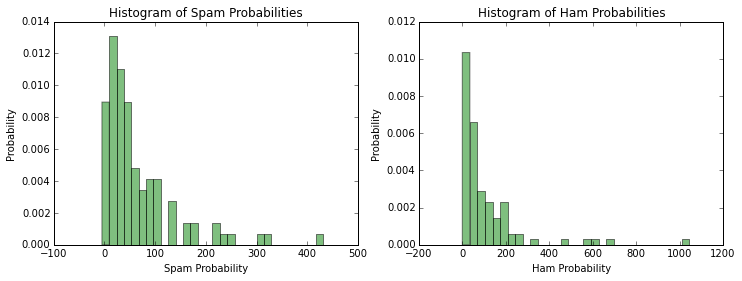

In [58]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import libraries for plotting and analysis
import matplotlib.pyplot as plt
import numpy as np
import re

# Initialize data structures
doc, Y, prediction, log_prob_spam, log_prob_ham = [], [], [], [], []

# Read in data from text file
with open('predict2_output.txt', 'r') as myfile:
    for line in myfile:
        fields = line.split()

        # Only look at records that have a doc_id as the first field
        pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
        try:
            key = fields[0]
        except:
            continue
        if pattern.match(fields[0]):
            doc.append(fields[0])
            Y.append(fields[1])
            prediction.append(fields[2])
            log_prob_spam.append(fields[3])
            log_prob_ham.append(fields[4])

# Convert to numpy arrays
doc = np.array(doc)
Y = np.array(Y)
prediction = np.array(prediction)
log_prob_spam = np.array(log_prob_spam).astype(np.float)
log_prob_ham = np.array(log_prob_ham).astype(np.float)

num_bins = 30
plt.figure(figsize=(12, 4))

# Print spam histogram
plt.subplot(1, 2, 1)
plt.hist(log_prob_spam, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.xlabel('Spam Probability')
plt.ylabel('Probability')
plt.title(r'Histogram of Spam Probabilities')

# Print ham histogram
plt.subplot(1, 2, 2)
plt.hist(log_prob_ham, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.xlabel('Ham Probability')
plt.ylabel('Probability')
plt.title(r'Histogram of Ham Probabilities')

### HW2.4: Repeat HW2.3 with the following modification: use Laplace plus-one smoothing.

#### Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

### HW2.5: Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. 

#### How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset?

### HW2.6: Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

- Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error

In [59]:
# General libraries
from __future__ import division

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [62]:
# Read data in and create data and label arrays
ids, X, Y = [], [], []

with open('enronemail_1h.txt', 'r') as myfile:
    for line in myfile:
        fields = line.split("\t")
        
        # Some records are malformed, so make sure that we take the right fields
        subj, body = "", ""
        
        if len(fields) >= 3:
            subj = fields[2]
        if len(fields) >= 4:
            body = fields[3]

        text = subj + " " + body
        text = text.replace("\n", "")
        X.append(text)
        Y.append(fields[1])
        ids.append(fields[0])

# Convert these to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Check that the shapes look correct
print X.shape, Y.shape

(100L,) (100L,)


In [84]:
def hw2_6():
    train_errors = {}
    
    ##### MULTINOMIAL NB
    # Create Pipeline to get feature vectors and train
    # Use CountVectorizer to get feature arrays
    # Classify using Multinomial NB
    mnb_pipe = Pipeline([('vect', CountVectorizer()),
                         ('clf', MultinomialNB()),
                        ])

    # Fit training data and labels
    mnb_pipe.fit(X, Y)

    # Print training error
    mnb_predictions = mnb_pipe.predict(X)
    train_errors["SK-learn MultinomialNB"] = sum(mnb_predictions != Y) / Y.size
    
    
    ##### CLASSIFIER in HW2.3
    # Read output from results
    
    incorrect = 0.0
    total = 0.0

    # Read in data from text file
    with open('predict2_output.txt', 'r') as myfile:
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                total += 1
                if fields[1] != fields[2]: incorrect += 1
    
    train_errors["HW2.3 (no smoothing)"] = incorrect/total
    
    
    ##### CLASSIFIER in HW2.4
    # Read output from results
    
    incorrect = 0.0
    total = 0.0

    # Read in data from text file
    with open('', 'r') as myfile:
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                total += 1
                if fields[1] != fields[2]: incorrect += 1
    
    train_errors["HW2.4 (+1 smoothing)"] = incorrect/total
    
    ##### CLASSIFIER in HW2.5
    # Read output from results
    
    incorrect = 0.0
    total = 0.0

    # Read in data from text file
    with open('', 'r') as myfile:
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                total += 1
                if fields[1] != fields[2]: incorrect += 1
    
    train_errors["HW2.5 (drop words <3)"] = incorrect/total
    
    ##### TABLE OF TRAINING ERRORS
    print "{:<25s}{:>6s}".format("Method", "Error")
    print "--------------------------------"
    for method in train_errors:
        print "{:<25s}{:>6.0%}".format(method, train_errors[method])
    
hw2_6()

Method                    Error
--------------------------------
SK-learn MultinomialNB       0%
HW2.4 (+1 smoothing)        83%
HW2.5 (drop words <3)       83%
HW2.3 (no smoothing)        83%


#### Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn